In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import string
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchviz import make_dot

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.EMNIST(
    root='./data', 
    split='letters',
    train=True, 
    transform=transform, 
    download=True
)

test_dataset = datasets.EMNIST(
    root='./data', 
    split='letters',
    train=False, 
    transform=transform, 
    download=True
)

In [3]:
calss_to_char = {}

for i,char in enumerate(string.ascii_letters[:26]):
    calss_to_char[i] = char.upper()
for i,char in enumerate(string.ascii_letters[26:]):
    calss_to_char[i] = char.lower()

In [4]:
augmentation = transforms.Compose([
  transforms.RandomRotation(15),
  transforms.RandomAffine(0, translate=(0.1, 0.1)),
  transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

In [5]:
class LetterCnn(nn.Module):
    def __init__(self):
        super(LetterCnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 52)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [6]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)



In [7]:
def train_model(device, train_loader, val_loader, num_epochs=20):
    model = LetterCnn()
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        'min',
        patience=3,
        factor=0.5,
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    model.to(device)
    best_val_acc = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        val_loss, val_accuracy = validate(model, val_loader, device, criterion)
        scheduler.step(val_loss)
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch+1}: Train Loss={running_loss/len(train_loader.dataset):.4f}, Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.4f}")

    model.load_state_dict(torch.load('best_model.pth', weights_only=True))
    return model


def validate(model, val_loader, device, criterion):
    model.eval()
    correct = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    val_loss = total_loss / len(val_loader.dataset)
    val_accuracy = correct / len(val_loader.dataset)
    return val_loss, val_accuracy



In [8]:
def plot_confusion(model, test_loader, device):
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(15,12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=string.ascii_uppercase[:26]+string.ascii_lowercase[26:],
                yticklabels=string.ascii_uppercase[:26]+string.ascii_lowercase[26:])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    plt.savefig('confusion_matrix.png')

In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train_model(device, train_loader, val_loader, num_epochs=20)

Epoch 1: Train Loss=0.0193, Val Loss=0.0159, Val Accuracy=0.9147
Epoch 2: Train Loss=0.0150, Val Loss=0.0147, Val Accuracy=0.9316
Epoch 3: Train Loss=0.0142, Val Loss=0.0143, Val Accuracy=0.9375
Epoch 4: Train Loss=0.0138, Val Loss=0.0139, Val Accuracy=0.9411
Epoch 5: Train Loss=0.0135, Val Loss=0.0138, Val Accuracy=0.9433
Epoch 6: Train Loss=0.0132, Val Loss=0.0136, Val Accuracy=0.9446
Epoch 7: Train Loss=0.0130, Val Loss=0.0136, Val Accuracy=0.9463
Epoch 8: Train Loss=0.0129, Val Loss=0.0135, Val Accuracy=0.9482
Epoch 9: Train Loss=0.0128, Val Loss=0.0136, Val Accuracy=0.9450
Epoch 10: Train Loss=0.0127, Val Loss=0.0135, Val Accuracy=0.9480
Epoch 11: Train Loss=0.0126, Val Loss=0.0135, Val Accuracy=0.9466
Epoch 12: Train Loss=0.0125, Val Loss=0.0135, Val Accuracy=0.9469
Epoch 13: Train Loss=0.0124, Val Loss=0.0135, Val Accuracy=0.9454
Epoch 14: Train Loss=0.0123, Val Loss=0.0135, Val Accuracy=0.9472
Epoch 15: Train Loss=0.0121, Val Loss=0.0134, Val Accuracy=0.9488
Epoch 16: Train Los

LetterCnn(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=52, bias=True)
)


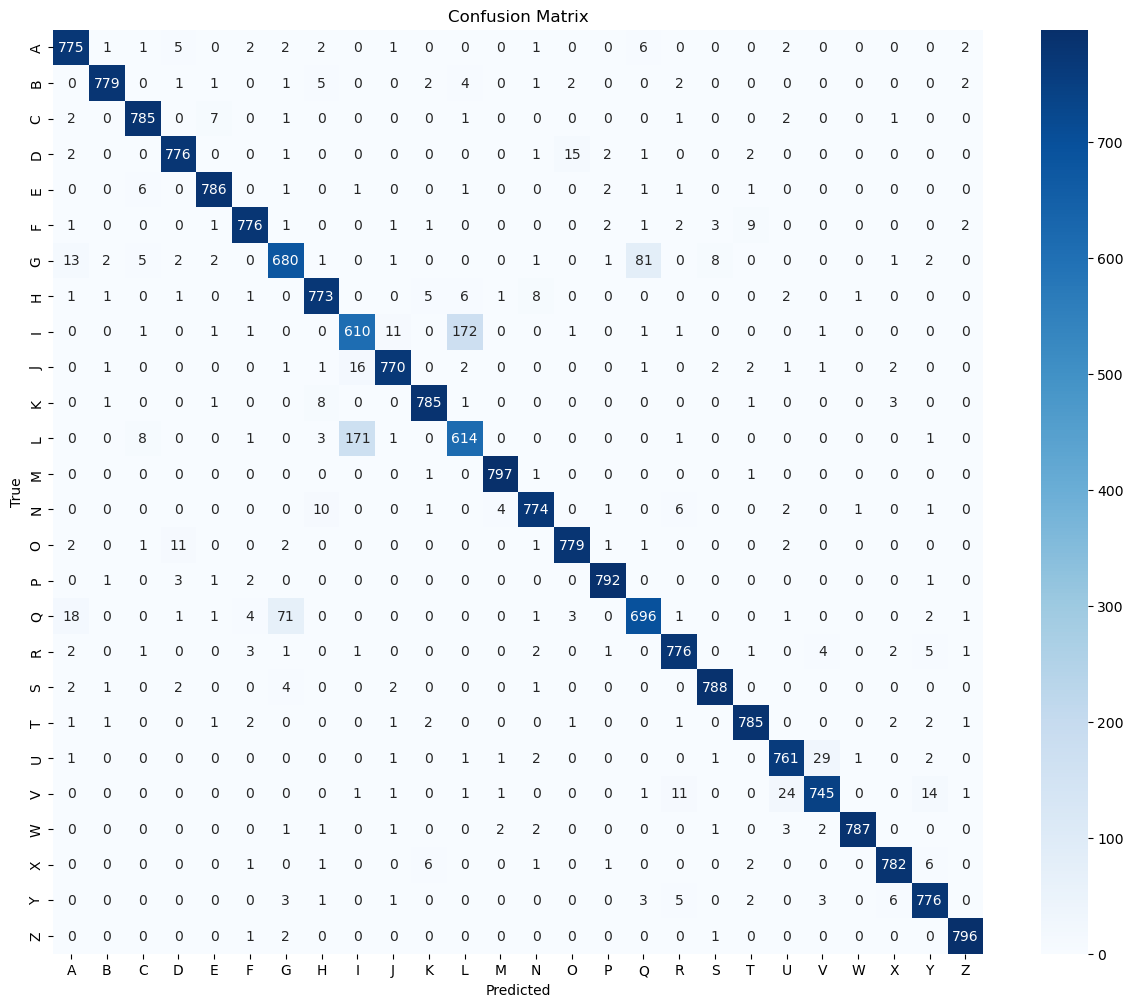

In [10]:
print(model)
plot_confusion(model, val_loader, device)

In [11]:
x = torch.randn(1, 1, 28, 28).to(device)  # 批次大小为1，通道数为1，高度和宽度为28
y = model(x)

# 可视化模型结构
dot = make_dot(y, params=dict(list(model.named_parameters())))
dot.format = 'png'
dot.render('letter_cnn_torchviz', format='png', cleanup=True)  # 保存为PNG文件
dot.view()  # 显示图形


'letter_cnn_torchviz.png'